# 1. Data Preprocessing

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('archive/EEG_data.csv')
data.describe()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln
count,12811.000000,12811.000000,12811.000000,12811.000000,12811.000000,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,1.281100e+04,12811.000000,12811.000000
mean,4.487394,4.390602,41.313871,47.182656,65.570760,6.057853e+05,1.680526e+05,4.138435e+04,3.318339e+04,2.431837e+04,3.814433e+04,2.959255e+04,1.441597e+04,0.479978,0.512606
std,2.865373,2.913232,23.152953,22.655976,597.921035,6.376236e+05,2.441346e+05,7.243082e+04,5.831410e+04,3.837968e+04,7.906606e+04,7.982637e+04,3.603523e+04,0.499618,0.499861
min,0.000000,0.000000,0.000000,0.000000,-2048.000000,4.480000e+02,1.700000e+01,2.000000e+00,2.000000e+00,3.000000e+00,2.000000e+00,1.000000e+00,2.000000e+00,0.000000,0.000000
25%,2.000000,2.000000,27.000000,37.000000,-14.000000,9.806400e+04,2.691750e+04,6.838000e+03,6.852000e+03,6.140000e+03,7.358500e+03,4.058000e+03,2.167500e+03,0.000000,0.000000
50%,4.000000,4.000000,43.000000,51.000000,35.000000,3.954870e+05,8.133100e+04,1.750000e+04,1.495900e+04,1.281800e+04,1.581000e+04,9.763000e+03,5.116000e+03,0.000000,1.000000
75%,7.000000,7.000000,57.000000,63.000000,90.000000,9.166230e+05,2.052760e+05,4.477950e+04,3.455050e+04,2.740600e+04,3.549400e+04,2.488800e+04,1.266950e+04,1.000000,1.000000
max,9.000000,9.000000,100.000000,100.000000,2047.000000,3.964663e+06,3.007802e+06,1.369955e+06,1.016913e+06,1.067778e+06,1.645369e+06,1.972506e+06,1.348117e+06,1.000000,1.000000


In [2]:
info = pd.read_csv('archive/demographic_info.csv')
info = info.rename(columns={'subject ID':'SubjectID'})
info.head()

,SubjectID,age,ethnicity,gender
0,0,25,Han Chinese,M
1,1,24,Han Chinese,M
2,2,31,English,M
3,3,28,Han Chinese,F
4,4,24,Bengali,M


In [3]:
df = data.merge(info, how = 'inner', on='SubjectID')
df.columns = df.columns.str.strip()
df.head()

,SubjectID,VideoID,Attention,Mediation,Raw,Delta,Theta,Alpha1,Alpha2,Beta1,Beta2,Gamma1,Gamma2,predefinedlabel,user-definedlabeln,age,ethnicity,gender
0,0.0,0.0,56.0,43.0,278.0,301963.0,90612.0,33735.0,23991.0,27946.0,45097.0,33228.0,8293.0,0.0,0.0,25,Han Chinese,M
1,0.0,0.0,40.0,35.0,-50.0,73787.0,28083.0,1439.0,2240.0,2746.0,3687.0,5293.0,2740.0,0.0,0.0,25,Han Chinese,M
2,0.0,0.0,47.0,48.0,101.0,758353.0,383745.0,201999.0,62107.0,36293.0,130536.0,57243.0,25354.0,0.0,0.0,25,Han Chinese,M
3,0.0,0.0,47.0,57.0,-5.0,2012240.0,129350.0,61236.0,17084.0,11488.0,62462.0,49960.0,33932.0,0.0,0.0,25,Han Chinese,M
4,0.0,0.0,44.0,53.0,-8.0,1005145.0,354328.0,37102.0,88881.0,45307.0,99603.0,44790.0,29749.0,0.0,0.0,25,Han Chinese,M


In [4]:
# Check for missing values
print("Missing values in each column:\n", df.isnull().sum())

Missing values in each column:
 SubjectID             0
VideoID               0
Attention             0
Mediation             0
Raw                   0
Delta                 0
Theta                 0
Alpha1                0
Alpha2                0
Beta1                 0
Beta2                 0
Gamma1                0
Gamma2                0
predefinedlabel       0
user-definedlabeln    0
age                   0
ethnicity             0
gender                0
dtype: int64


### Filter

算band power

In [5]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.signal import butter, filtfilt

# # Define Butterworth bandpass filter functions
# def butter_bandpass(lowcut, highcut, fs, order=4):
#     """
#     Create a Butterworth bandpass filter.
#     :param lowcut: Lower frequency bound.
#     :param highcut: Upper frequency bound.
#     :param fs: Sampling frequency (Hz).
#     :param order: Order of the filter.
#     :return: Filter coefficients (b, a).
#     """
#     nyq = 0.5 * fs  # Nyquist frequency
#     low = lowcut / nyq
#     high = highcut / nyq
#     b, a = butter(order, [low, high], btype='band')
#     return b, a

# def bandpass_filter(data, lowcut, highcut, fs, order=4):
#     """
#     Apply a Butterworth bandpass filter to data.
#     :param data: Input 1D signal.
#     :param lowcut: Lower frequency bound.
#     :param highcut: Upper frequency bound.
#     :param fs: Sampling frequency.
#     :param order: Filter order.
#     :return: Filtered signal.
#     """
#     b, a = butter_bandpass(lowcut, highcut, fs, order)
#     y = filtfilt(b, a, data)
#     return y

# # Filter parameters
# fs = 2.0            # Sampling frequency in Hz
# lowcut = 0.1        # Lower cutoff frequency (Hz)
# highcut = 0.9       # Upper cutoff frequency (Hz)
# order = 4           # Filter order

# # Apply the filter to the "Raw" column
# df['Filtered'] = df['Raw'].apply(lambda x: bandpass_filter(x, lowcut, highcut, fs, order))
# df['Delta'] = df['Filtered'].apply(lambda x: bandpass_filter(x, 0.1, 4, fs, order))
# df['Theta'] = df['Filtered'].apply(lambda x: bandpass_filter(x, 4, 8, fs, order))
# df['Alpha'] = df['Filtered'].apply(lambda x: bandpass_filter(x, 8, 12, fs, order))
# df['Beta'] = df['Filtered'].apply(lambda x: bandpass_filter(x, 12, 30, fs, order))
# df['Gamma'] = df['Filtered'].apply(lambda x: bandpass_filter(x, 30, 100, fs, order))


# 2. Feature Extraction

In [6]:
df.columns

Index(['SubjectID', 'VideoID', 'Attention', 'Mediation', 'Raw', 'Delta',
       'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2',
       'predefinedlabel', 'user-definedlabeln', 'age', 'ethnicity', 'gender'],
      dtype='object')

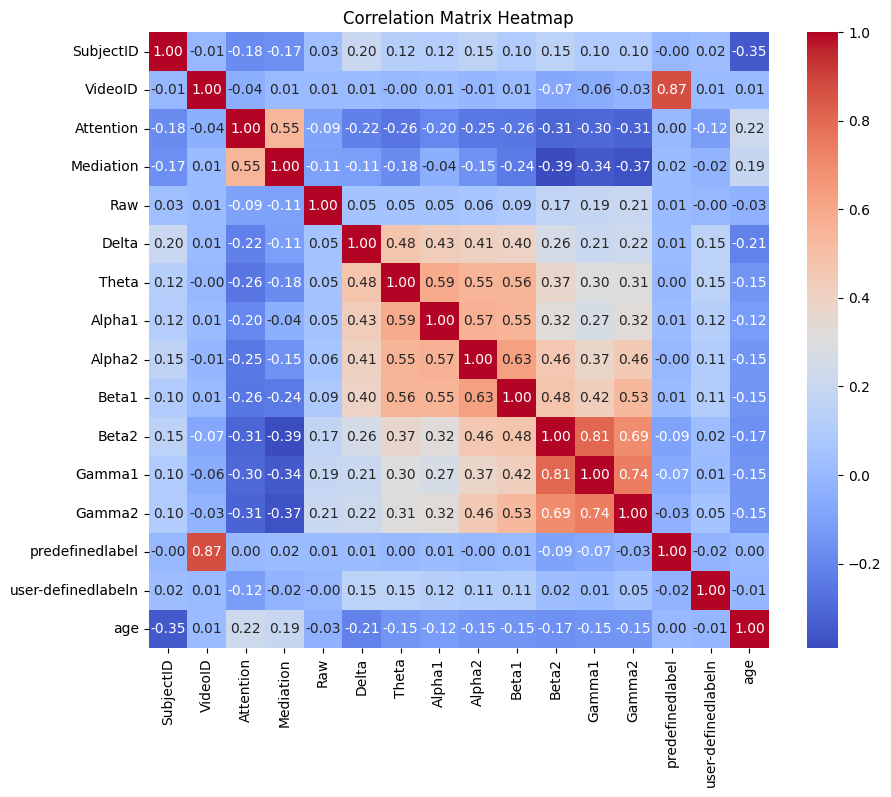

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.drop(columns=['ethnicity', 'gender']).corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

In [ ]:
import numpy as np
from scipy.signal import welch
import pywt

def compute_hjorth_parameters(signal):
    # First derivative
    diff_signal = np.diff(signal)
    # Second derivative
    diff2_signal = np.diff(diff_signal)
    var_signal = np.var(signal)
    var_diff = np.var(diff_signal)
    var_diff2 = np.var(diff2_signal)
    # Avoid division by zero
    if var_signal == 0:
        mobility = 0
        complexity = 0
    else:
        mobility = np.sqrt(var_diff / var_signal)
        mobility_diff = np.sqrt(var_diff2 / var_diff) if var_diff != 0 else 0
        complexity = mobility_diff / mobility if mobility != 0 else 0
    return mobility, complexity

def extract_time_domain_features(signal):
    mean_val = np.mean(signal)
    variance_val = np.var(signal)
    mobility, complexity = compute_hjorth_parameters(signal)
    return {
        'mean': mean_val,
        'variance': variance_val,
        'hjorth_mobility': mobility,
        'hjorth_complexity': complexity
    }

def extract_frequency_domain_features(signal, fs):
    # Compute PSD with Welch’s method
    freqs, psd = welch(signal, fs=fs, nperseg=256)
    bands = {
        'theta': (4, 7),
        'alpha': (8, 12),
        'beta': (13, 30)
    }
    band_powers = {}
    for band, (fmin, fmax) in bands.items():
        idx_band = np.logical_and(freqs >= fmin, freqs <= fmax)
        band_power = np.trapz(psd[idx_band], freqs[idx_band])
        band_powers[band] = band_power
    return band_powers

def extract_wavelet_features(signal, wavelet='db4', level=4):
    # Perform discrete wavelet transform
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    # Compute energy (sum of squares) of coefficients at each level
    energies = [np.sum(c ** 2) for c in coeffs]
    return energies

def extract_features(eeg_data, fs):
    """
    Extract features for each channel.
    Assumes eeg_data is a NumPy array of shape (n_samples, n_channels).
    """
    n_channels = eeg_data.shape[1]
    features = {}
    for ch in range(n_channels):
        channel_data = eeg_data[:, ch]
        # Time-domain features
        time_features = extract_time_domain_features(channel_data)
        # Frequency-domain features: compute PSD band powers
        freq_features = extract_frequency_domain_features(channel_data, fs)
        # Wavelet features: energy of wavelet coefficients
        wavelet_features = extract_wavelet_features(channel_data)
        
        features[f'channel_{ch}'] = {
            'time_domain': time_features,
            'frequency_domain': freq_features,
            'wavelet_energies': wavelet_features
        }
    return features

# Example usage:
if __name__ == "__main__":
    fs = 2.0  # Sampling frequency in Hz (samples per second)
    
    # Load your real data
    # Assuming 'data' is a pandas DataFrame with the relevant columns
    columns_to_use = ['Raw', 'Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2']
    eeg_data = filtered_data[columns_to_use].values
    
    features = extract_features(eeg_data, fs)
    print(features)

{'channel_0': {'time_domain': {'mean': np.float64(-0.06721103244134545), 'variance': np.float64(316978.4216156411), 'hjorth_mobility': np.float64(1.4196882964100552), 'hjorth_complexity': np.float64(1.026247959453825)}, 'frequency_domain': {'theta': np.float64(0.0), 'alpha': np.float64(0.0), 'beta': np.float64(0.0)}, 'wavelet_energies': [np.float64(1241223.9788480503), np.float64(17901110.364420254), np.float64(72052859.49896343), np.float64(1808923181.7926219), np.float64(2162242410.3443737)]}, 'channel_1': {'time_domain': {'mean': np.float64(-32.24029707388006), 'variance': np.float64(240323981335.0428), 'hjorth_mobility': np.float64(1.4079051528811561), 'hjorth_complexity': np.float64(1.1681071748328284)}, 'frequency_domain': {'theta': np.float64(0.0), 'alpha': np.float64(0.0), 'beta': np.float64(0.0)}, 'wavelet_energies': [np.float64(13994319704379.643), np.float64(91621961241590.77), np.float64(447558541284841.25), np.float64(1043893982164439.2), np.float64(1499045965620902.5)]}, 

/var/folders/fx/y_280p6163z34zdr5fpg79lc0000gn/T/ipykernel_48165/506721315.py:45: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  band_power = np.trapz(psd[idx_band], freqs[idx_band])


# 3. Model Development

Since this dataset only has one channel, CSP is not applicable. CSP relies on spatial information, which requires multiple EEG channels.

baseline model

leave one out<br>
fft algorithm<br>
cross validation


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming your DataFrame is named df and you have defined your features and target
# Replace 'features' with your actual feature column names and 'target' with your target column name
X = filtered_data[['SubjectID', 'Raw', 'Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2']]
y = filtered_data['predefinedlabel']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest classifier
model = RandomForestClassifier()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.58


other try

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Assuming your DataFrame is named filtered_data and you have defined your features and target
# Replace 'features' with your actual feature column names and 'target' with your target column name
X = filtered_data[['SubjectID', 'Attention', 'Mediation', 'Raw', 'Delta', 'Theta', 'Alpha1', 'Alpha2', 'Beta1', 'Beta2', 'Gamma1', 'Gamma2']]
y = filtered_data['predefinedlabel']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Create a pipeline with StandardScaler and RandomForestClassifier using make_pipeline
pipeline = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(
        n_estimators=300,        # Number of trees in the forest
        max_depth=10,            # Maximum depth of the tree
        random_state=42          # Random seed for reproducibility
    )
)

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.61


In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create an XGBoost classifier
model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=1000, seed=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.61
